In [30]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
 
#Import IMDB dataset:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

maxlen = 200
vocab_size = 10000

#Pad sequences:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 200)
x_test shape: (25000, 200)


In [31]:
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras import ops

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [32]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [36]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=3, validation_split=0.3
)

Epoch 1/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.6812 - loss: 0.5544 - val_accuracy: 0.8753 - val_loss: 0.2857
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.9157 - loss: 0.2196 - val_accuracy: 0.8812 - val_loss: 0.2913
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.9480 - loss: 0.1396 - val_accuracy: 0.8729 - val_loss: 0.3249


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


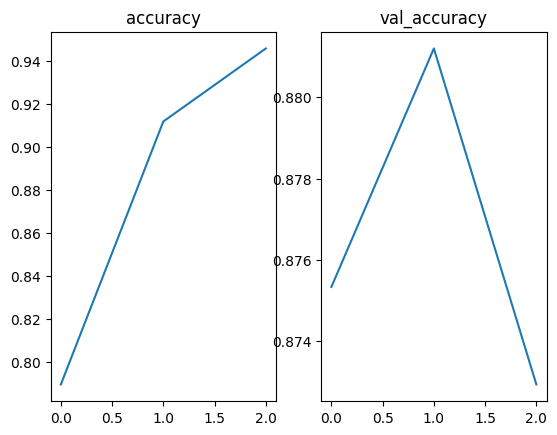

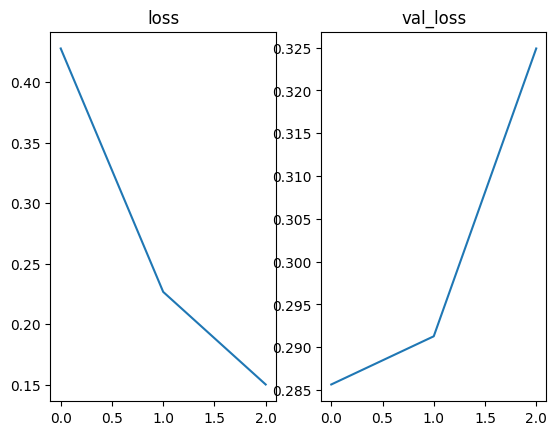

In [ ]:
from matplotlib import pyplot as plt

def plot_metrics(history):
    history_dict = history.history
    # print(history_dict.keys())
    _, ax = plt.subplots(1, 2)
    ax[0].plot(history_dict['accuracy'])
    ax[0].set_title('accuracy')
    ax[1].plot(history_dict['val_accuracy'])
    ax[1].set_title('val_accuracy')
    plt.show()

    _, ax = plt.subplots(1, 2)
    ax[0].plot(history_dict['loss'])
    ax[0].set_title('loss')
    ax[1].plot(history_dict['val_loss'])
    ax[1].set_title('val_loss')
    plt.show()
    

plot_metrics(history)

## Vision transformers

In [ ]:
from keras_vit.vit import ViT_B32
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [10]:
IMG_SIZE = 150
 
base_dir = "dataset_cats_dogs"
cat_dir = os.path.join(base_dir, "cats")
dog_dir = os.path.join(base_dir, "dogs")

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

train_dataset = image_dataset_from_directory(
    train_dir,  # This is the target directory
    labels="inferred", 
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(IMG_SIZE,IMG_SIZE), # All images have different sizes and will be resized to 150x150
    shuffle=False,
)

val_dataset = image_dataset_from_directory(
    val_dir,  # This is the target directory
    labels="inferred", 
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(IMG_SIZE,IMG_SIZE), # All images have different sizes and will be resized to 150x150
    shuffle=False,
)

test_dataset = image_dataset_from_directory(
    test_dir,  # This is the target directory
    labels="inferred", 
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(IMG_SIZE,IMG_SIZE), # All images have different sizes and will be resized to 150x150
    shuffle=False,
)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        # Set target directory:
        train_dir,
        # Resize images to 150x150 pixels:
        target_size=(IMG_SIZE, IMG_SIZE),
        # Experiment with different batches:
        batch_size=20,
        # Labels needed for binary_crossentropy loss:
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=20,
        class_mode='binary')


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
vit_model = ViT_B32(
        image_size = IMG_SIZE,
        num_classes=2,
        dropout_rate=0.1,
        pre_trained = True,
        pre_logits=False,
        weights="imagenet21k"
    )
 

AttributeError: Exception encountered when calling AddCLSToken.call().

[1mCould not automatically infer the output shape / dtype of 'add_cls_token' (of type AddCLSToken). Either the `AddCLSToken.call()` method is incorrect, or you need to implement the `AddCLSToken.compute_output_spec() / compute_output_shape()` method. Error encountered:

module 'keras.api.backend' has no attribute 'tile'[0m

Arguments received by AddCLSToken.call():
  • args=('<KerasTensor shape=(None, 16, 768), dtype=float32, sparse=False, ragged=False, name=keras_tensor_7>',)
  • kwargs=<class 'inspect._empty'>